In [1]:
import matplotlib.pyplot as plt
import json
import pandas as pd
import seaborn as sns

In [2]:
with open("../eval_results/perplexity/ppl_base_lang_neurons.json") as f:
    data1 = json.load(f)

with open("../eval_results/perplexity/ppl_base.json") as f:
    data2 = json.load(f)

In [3]:
data = {lang:{} for lang in data1}

mappings = [("mpq 4 ln", "mpq 4 ln"), 
            ("mpq 4 random", "mpq 4 rng"), 
            ("mpqr 4 ln", "mpqr 4 ln"), 
            ("mpqr 4 random", "mpqr 4 rng")]

langs = ["en", "fr", "es", "vi", "id", "zh", "ru", "uk", "hi"] 

for lang in langs:
    data[lang]["hf 16"] = data2[lang]["hf 16"]
    data[lang]["rtn 4"] = data2[lang]["rtn 4"]
for lang in langs:
    for quant, alt_name in mappings:
        data[lang][alt_name] = data1[lang][quant]

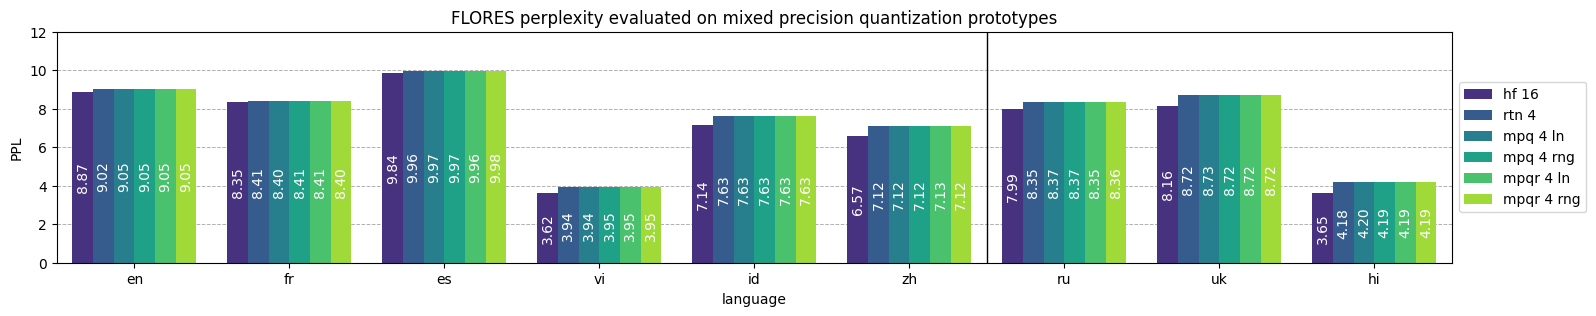

In [4]:
df = []
for n, lang in enumerate(langs):
    for quant in data[lang]:
        df.append([lang, quant, data[lang][quant]["perplexity"]])
df = pd.DataFrame(df, columns=["language", "quant", "PPL"])

plt.figure(figsize=(18, 3), dpi=100)

ax = sns.barplot(x="language", y="PPL", hue="quant", palette="viridis", data=df, saturation=1)
for container in ax.containers:
    labels = ax.bar_label(container, label_type="center", color="white", padding=0, fmt='%.2f')
    for label in labels:
        label.set_rotation(90)
# plt.yscale("log")
ax.set_ylim(0, 12)
plt.axvline(x=5.5, color='black', linestyle='-', linewidth=1)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(axis="y", which="both", zorder=-10000, linewidth=0.7, linestyle="--")
ax.set_axisbelow(True)
plt.title("FLORES perplexity evaluated on mixed precision quantization prototypes")
plt.show()

In [5]:
# Based on the tokenized length of the concatenated FLORES sequences
raw_text_sizes = [ 31738,  45407,  45268,  88465,  54432,  60545,  51274,  53536, 137103]
text_sizes = [t / raw_text_sizes[0] for t in raw_text_sizes]
text_sizes

[1.0,
 1.4306824626630537,
 1.4263028546222194,
 2.787352700233159,
 1.7150419056021173,
 1.9076501354842774,
 1.6155397315520827,
 1.6868107631230702,
 4.319837418866974]

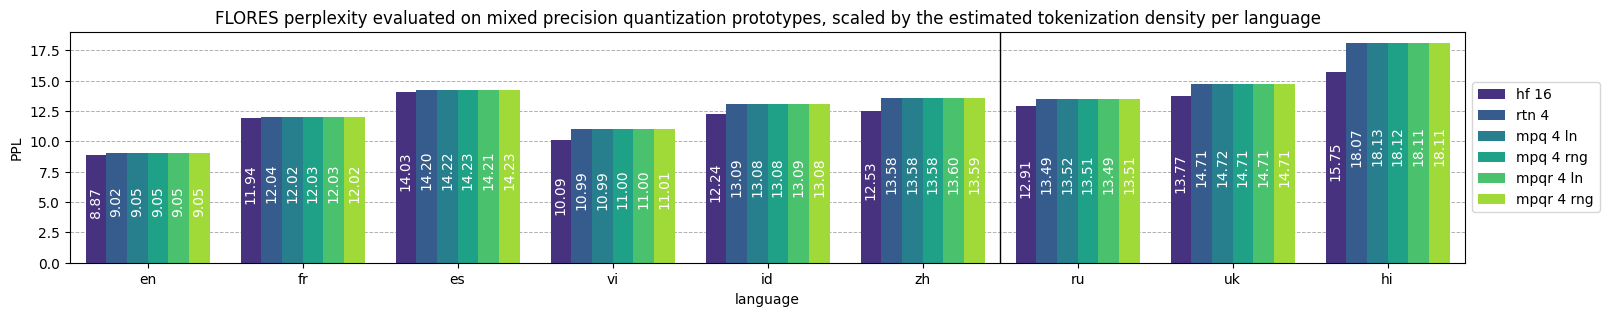

In [6]:
df = []
for n, lang in enumerate(langs):
    for quant in data[lang]:
        df.append([lang, quant, data[lang][quant]["perplexity"] * text_sizes[n]])
df = pd.DataFrame(df, columns=["language", "quant", "PPL"])

plt.figure(figsize=(18, 3), dpi=100)

# plt.title("Model perplexity evaluated on various languages of FLORES, directly scaled up by estimated tokenization density")

ax = sns.barplot(x="language", y="PPL", hue="quant", palette="viridis", data=df, saturation=1)
for container in ax.containers:
    labels = ax.bar_label(container, label_type="center", color="white", padding=5, fmt='%.2f')
    for label in labels:
        label.set_rotation(90)
# plt.yscale("log")
# ax.set_ylim(0, 19)

plt.axvline(x=5.5, color='black', linestyle='-', linewidth=1)
ax.grid(axis="y", which="both", zorder=-10000, linewidth=0.7, linestyle="--")
ax.set_axisbelow(True)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("FLORES perplexity evaluated on mixed precision quantization prototypes, scaled by the estimated tokenization density per language")
plt.show()

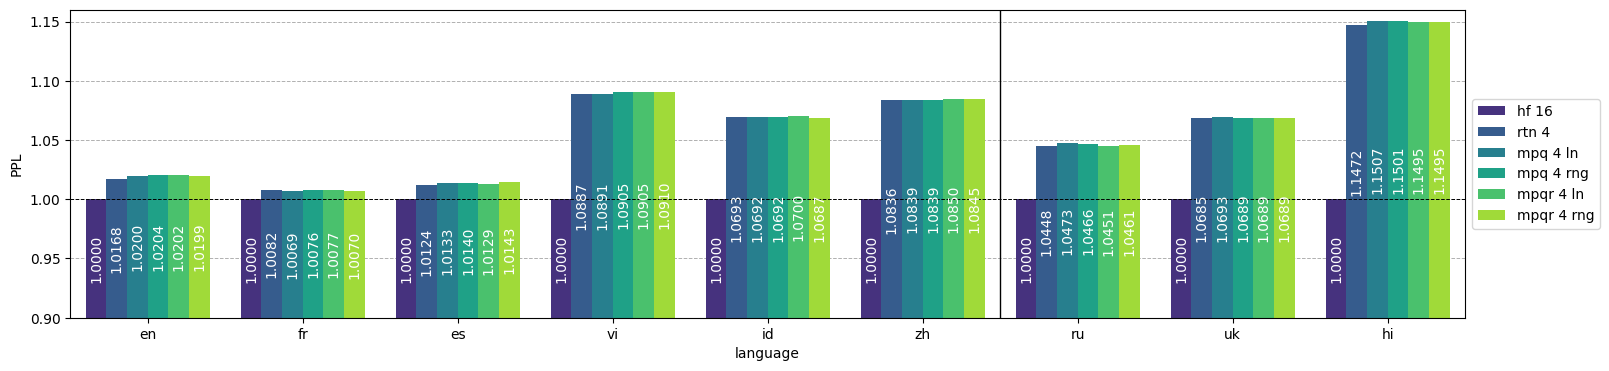

In [7]:
df = []
for n, lang in enumerate(langs):
    for quant in data[lang]:
        df.append([lang, quant, data[lang][quant]["perplexity"]/data[lang]["hf 16"]["perplexity"]])
df = pd.DataFrame(df, columns=["language", "quant", "PPL"])

plt.figure(figsize=(18, 4), dpi=100)

# plt.title("FLORES perplexity fraction proportional to the perplexity of the base model")

ax = sns.barplot(x="language", y="PPL", hue="quant", palette="viridis", data=df, saturation=1)
for container in ax.containers:
    labels = ax.bar_label(container, label_type="center", color="white", padding=0, fmt='%.4f')
    for label in labels:
        label.set_rotation(90)
# plt.yscale("log")
ax.set_ylim(0.9, 1.16)
ax.axhline(1, color='black', linestyle='--', linewidth=0.7)
plt.axvline(x=5.5, color='black', linestyle='-', linewidth=1)


ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(axis="y", which="both", zorder=-10000, linewidth=0.7, linestyle="--")
ax.set_axisbelow(True)
plt.show()

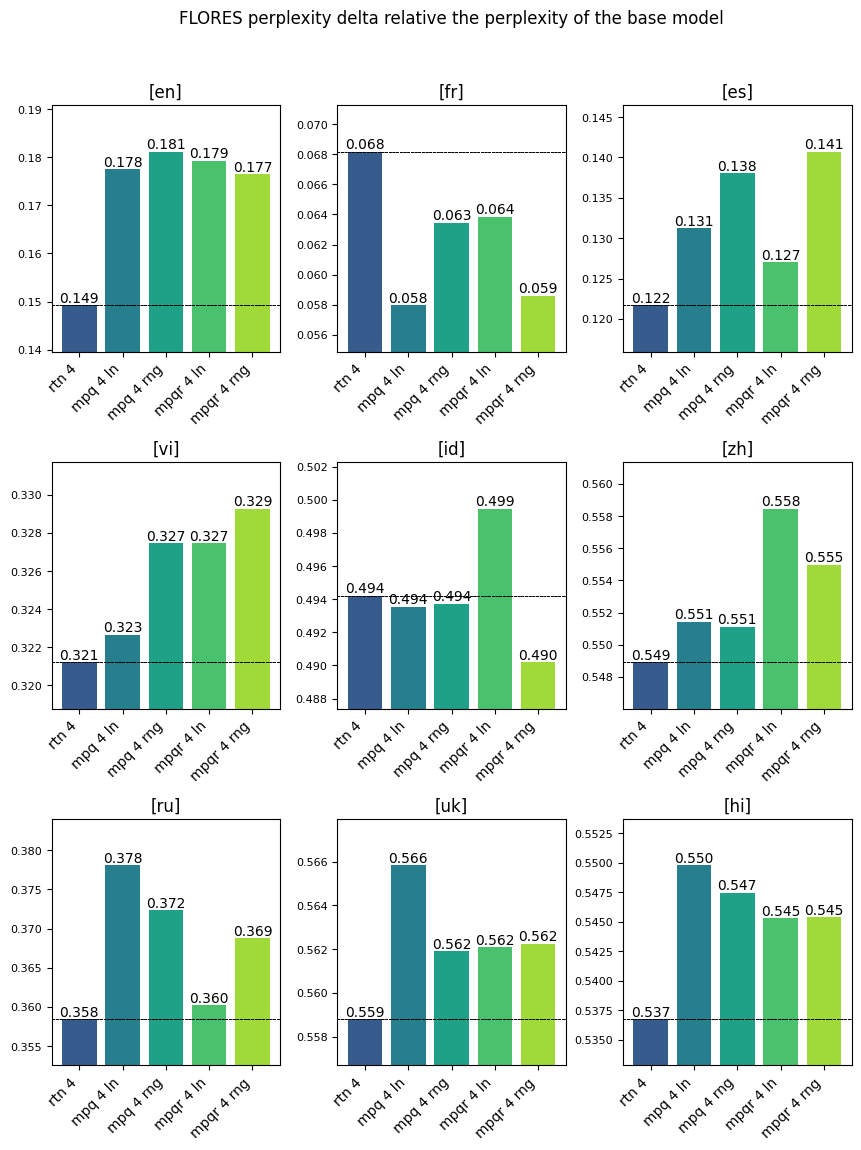

In [8]:
fig, axes = plt.subplots(3, 3, figsize=(10, 12), dpi=100)
axes = axes.reshape(-1)
fig.suptitle("FLORES perplexity delta relative the perplexity of the base model")
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.25, hspace=0.45)

for n, lang in enumerate(langs):
    cmap = plt.get_cmap('viridis')
    axes[n].set_title(f"[{lang}]")

    ref = data[lang]["rtn 4"]["perplexity"]-data[lang]["hf 16"]["perplexity"]
    res = [data[lang][method]["perplexity"]-data[lang]["hf 16"]["perplexity"] for method in data[lang]][1:]

    lo = min(res)
    hi = max(res)

    axes[n].set_ylim(lo-(hi-lo)*0.3, hi+(hi-lo)*0.3)
    axes[n].tick_params(axis='y', which='both', labelsize=8)

    for m, method in enumerate(list(data[lang].keys())[1:]):
        axes[n].axhline(ref, color='black', linestyle='--', linewidth=0.5)
        col = cmap((m+2)/(len(data[lang].keys())+1))
        br = axes[n].bar(method, res[m], color=col)
        axes[n].bar_label(br, fmt='%.3f')
    axes[n].set_xticks(axes[n].get_xticks(), axes[n].get_xticklabels(), rotation=45, ha='right')



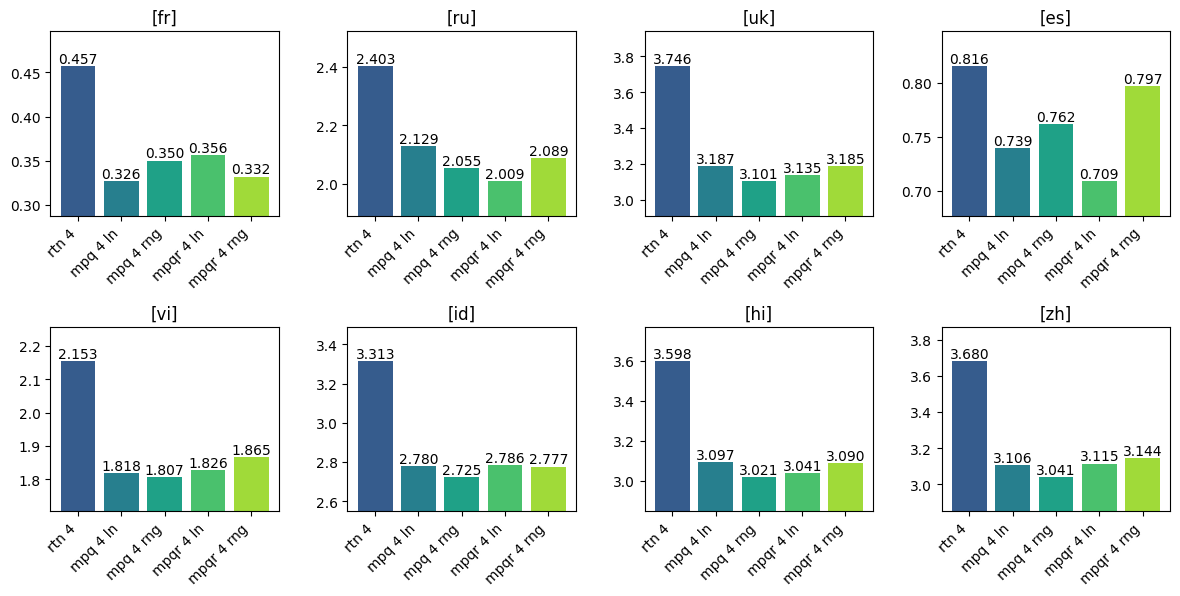

In [9]:
fig, axes = plt.subplots(2, 4, figsize=(14, 6), dpi=100)
axes = axes.reshape(-1)
# fig.suptitle("FLORES perplexity delta proportional to the [en] perplexity delta")
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.3, hspace=0.6)
for n, lang in enumerate(list(data.keys())[1:]):
    cmap = plt.get_cmap('viridis')
    axes[n].set_ylim(0, 6.3)
    axes[n].set_title(f"[{lang}]")

    res = [(data[lang][method]["perplexity"]-data[lang]["hf 16"]["perplexity"])
        /(data["en"][method]["perplexity"]-data["en"]["hf 16"]["perplexity"]) for method in list(data[lang])[1:]]
    
    lo = min(res[1:])
    hi = max(res)

    axes[n].set_ylim(lo-(hi-lo)*0.3, hi+(hi-lo)*0.3)

    for m, method in enumerate(list(data[lang].keys())[1:]):
    

        col = cmap((m+2)/(len(data[lang].keys())+1))
        br = axes[n].bar(method, res[m], color=col)
        axes[n].bar_label(br, fmt='%.3f')
    axes[n].set_xticks(axes[n].get_xticks(), axes[n].get_xticklabels(), rotation=45, ha='right')
    